In [63]:
%matplotlib inline
from matplotlib import pyplot as plt
from lolopy.learners import RandomForestRegressor
from sklearn.model_selection import KFold
import tqdm
import pandas as pd
import numpy as np
import combo

In [21]:
def MEI(X, y, n_steps, T):
    
    arr = y
    minima = arr.argsort()[0:100]
    in_train = np.zeros(len(X), dtype=np.bool)
    in_train[minima] = True

    all_inds = set(range(len(y)))
    F = np.zeros(n_steps)
    G = np.zeros(n_steps)
    mei_train = [list(set(np.where(in_train)[0].tolist()))]
    mei_train_inds = []

    for i in tqdm.tqdm(range(n_steps)):
        mei_train_inds = mei_train[-1].copy()    
        mei_search_inds = list(all_inds.difference(mei_train_inds))


        mei_selection_index = []
        for j in range(T):
            model.fit(X[mei_train_inds], y[mei_train_inds])
            mei_y_pred_prov = model.predict(X[mei_search_inds])
            mei_selection_index.append(np.argmax(mei_y_pred_prov)) 

        mei_index_G = max(set(mei_selection_index), key = mei_selection_index.count)
        mei_index = mei_search_inds[mei_index_G]
        mei_train_inds.append(mei_search_inds[mei_index_G])     # Pick entry with the largest maximum value
        mei_train.append(mei_train_inds)
        G[i] = mei_index
        F[i] = mei_train_inds[-1]
        if mei_train_inds[-1] == np.argmax(y):
            break
            
    return(F)



def MLI(X, y, n_steps, T):
    
    arr = y
    minima = arr.argsort()[0:100]
    in_train = np.zeros(len(X), dtype=np.bool)
    in_train[minima] = True
    
    all_inds = set(range(len(y)))
    K = np.zeros(n_steps)
    L = np.zeros(n_steps)
    mli_train = [list(set(np.where(in_train)[0].tolist()))]
    mli_train_inds = []


    for i in tqdm.tqdm(range(n_steps)):
        mli_train_inds = mli_train[-1].copy()    
        mli_search_inds = list(all_inds.difference(mli_train_inds))


        mli_selection_index = []
        for j in range(T):
            model.fit(X[mli_train_inds], y[mli_train_inds])
            mli_y_pred_prov, mli_y_std_prov = model.predict(X[mli_search_inds], return_std=True)
            mli_selection_index.append(np.argmax(np.divide(mli_y_pred_prov - np.max(y[mli_train_inds]), mli_y_std_prov))) 
            

        mli_index_L = max(set(mli_selection_index), key = mli_selection_index.count)
        mli_index = mli_search_inds[mli_index_L]

        mli_train_inds.append(mli_search_inds[mli_index_L])     # Pick entry with the largest maximum value
        mli_train.append(mli_train_inds)
        L[i] = mli_index
        K[i] = mli_train_inds[-1]
        if mli_train_inds[-1] == np.argmax(y):
            break

    return (K)


def MU(X, y, n_steps, T):
    
    arr = y
    minima = arr.argsort()[0:100]
    in_train = np.zeros(len(X), dtype=np.bool)
    in_train[minima] = True
    
    all_inds = set(range(len(y)))
    R = np.zeros(n_steps)
    S = np.zeros(n_steps)
    mu_train = [list(set(np.where(in_train)[0].tolist()))]
    mu_train_inds = []


    for i in tqdm.tqdm(range(n_steps)):
        mu_train_inds = mu_train[-1].copy()    
        mu_search_inds = list(all_inds.difference(mu_train_inds))


        mu_selection_index = []
        for j in range(T):
            model.fit(X[mu_train_inds], y[mu_train_inds])
            mu_y_pred_prov, mu_y_std_prov = model.predict(X[mu_search_inds], return_std=True)
            mu_selection_index.append(np.argmax(mu_y_std_prov)) 

        mu_index_R = max(set(mu_selection_index), key = mu_selection_index.count)
        mu_index = mu_search_inds[mu_index_R]

        mu_train_inds.append(mu_search_inds[mu_index_R])     # Pick entry with the largest maximum value
        mu_train.append(mu_train_inds)
        R[i] = mu_index
        S[i] = mu_train_inds[-1]
        if mu_train_inds[-1] == np.argmax(y):
            break

    return (S)

In [61]:
def COMBO(Data, acq_fcn):

    class simulator:
        def __init__( self ):
            _, self.y = load_data()

        def __call__( self, action ):
            return self.y[action]
    
    def load_data():
        X = Data.iloc[:, :-1].values
        y = Data.iloc[:, -1].values
        return X, y
    
    X, y = load_data()
    X = combo.misc.centering(X)
        
    arr = y
    minima = arr.argsort()[0:100]
    
    policy = combo.search.discrete.policy(test_X = X) 
    t  = simulator()(minima)
    res = policy.write(minima, t)
    
    res = policy.bayes_search(max_num_probes = 400, simulator=simulator(), score = acq_fcn, interval=50, num_rand_basis=0)
    
    return(res)

In [3]:
def produce_Data_SL(Data, Output_mean_shap, n_relevant, target_property):

    relevant_features = list(Output_mean_shap.iloc[:n_relevant].index)
    unrelevant_features = list(Output_mean_shap.sort_values('mean').iloc[:int(100-n_relevant)].index)
    all_features = relevant_features + unrelevant_features

    relevant_features.append(target_property)
    all_features.append(target_property)

    Data_sampled = Data.sample(n = 500, random_state = 0)
    
    if target_property == 'henry_coefficient_CO2_298K [mol/kg/bar]' or target_property == 'henry_coefficient_H2O_298K [mol/kg/bar]':
        Data_sampled[target_property] = np.log(Data_sampled[target_property])
        
    Data_relevant_features = pd.DataFrame(Data_sampled, columns = relevant_features)
    Data_unrelevant_features = pd.DataFrame(Data_sampled, columns = all_features)
    
    return (Data_relevant_features, Data_unrelevant_features)

In [4]:
Data_Henry_CO2        = pd.read_excel(r'Data_Henry_CO2.xlsx', index_col = 0)
Data_Working_Capacity = pd.read_excel(r'Data_Working_Capacity.xlsx', index_col = 0)
Data_Henry_H2O        = pd.read_excel(r'Data_Henry_H2O.xlsx', index_col = 0)
#Data_Surface_area     = pd.read_excel(r'Data_Surface_area.xlsx', index_col = 0)

In [5]:
Output_mean_shap_Henry_CO2        = pd.read_excel(r'Output_mean_shap_Henry_CO2.xlsx', index_col = 0)
Output_mean_shap_Working_Capacity = pd.read_excel(r'Output_mean_shap_Working_capacity.xlsx', index_col = 0)
Output_mean_shap_Henry_H2O        = pd.read_excel(r'Output_mean_shap_Henry_H2O.xlsx', index_col = 0)
#Output_mean_shap_surface_area     = pd.read_excel(r'Output_mean_shap_surface_area.xlsx', index_col = 0)

In [39]:
Data_relevant_features_Henry_CO2, Data_unrelevant_features_Henry_CO2               = produce_Data_SL(Data_Henry_CO2, Output_mean_shap_Henry_CO2, 33, 'henry_coefficient_CO2_298K [mol/kg/bar]')
Data_relevant_features_Working_Capacity, Data_unrelevant_features_Working_Capacity = produce_Data_SL(Data_Working_Capacity, Output_mean_shap_Working_Capacity, 62, 'working_capacity_vacuum_swing_REPEAT_chg [mmol/g]')
Data_relevant_features_Henry_H2O, Data_unrelevant_features_Henry_H2O               = produce_Data_SL(Data_Henry_H2O, Output_mean_shap_Henry_H2O, 15, 'henry_coefficient_H2O_298K [mol/kg/bar]')
#Data_relevant_features_surface_area, Data_unrelevant_features_surface_area         = produce_Data_SL(Data_Surface_area, Output_mean_shap_surface_area, 14, 'surface_area [m^2/g]')

In [89]:
#Data_unrelevant_features_Henry_H2O.to_excel('C:\\Users\\giovanni\\Desktop\\Excels Matlab\\Data_unrelevant_features_Henry_H2O.xlsx')

## Henry CO2
#### Relevant features

In [24]:
model = RandomForestRegressor()

In [25]:
MEI_index_Henry_CO2_relevant = MEI(Data_relevant_features_Henry_CO2.iloc[:, :-1].values, Data_relevant_features_Henry_CO2.iloc[:, -1].values, 400, 100)

 28%|██▊       | 111/400 [1:09:43<3:01:31, 37.69s/it]


In [26]:
MLI_index_Henry_CO2_relevant = MLI(Data_relevant_features_Henry_CO2.iloc[:, :-1].values, Data_relevant_features_Henry_CO2.iloc[:, -1].values, 400, 100)

 18%|█▊        | 74/400 [41:39<3:03:30, 33.77s/it]


In [27]:
MU_index_Henry_CO2_relevant = MU(Data_relevant_features_Henry_CO2.iloc[:, :-1].values, Data_relevant_features_Henry_CO2.iloc[:, -1].values, 400, 100)

 34%|███▎      | 134/400 [1:43:47<3:26:01, 46.47s/it]


In [64]:
COMBO_PI_Henry_CO2_relevant = COMBO(Data_relevant_features_Henry_CO2, 'PI')

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood 54.76843695353331
50-th epoch, marginal likelihood 32.61917843281164
100-th epoch, marginal likelihood 19.318970303584706
150-th epoch, marginal likelihood 10.321649484617453
200-th epoch, marginal likelihood 4.148311083608718
250-th epoch, marginal likelihood -0.07154457746423759
300-th epoch, marginal likelihood -2.9058282773172834
350-th epoch, marginal likelihood -5.169621934066711
400-th epoch, marginal likelihood -6.4519848474028265
450-th epoch, marginal likelihood -7.858639216611543
500-th epoch, marginal likelihood -8.884347277564217
Done

 Parameters of Gaussian kernel 
 
 width  =  [3.]
 scale  =  1.0
 scale2 =  1.0
 

0101-th step: f(x) = 11.087779 (action=150)
   current best f(x) = 11.087779 (best action=150) 

0102-th step: f(x) = 11.193615 (action=277)
   current best f(x) = 11.193615 (best action=277) 

0103-th step: f(x) = 10.909970 (action=166)

In [69]:
COMBO_EI_Henry_CO2_relevant = COMBO(Data_relevant_features_Henry_CO2, 'EI')

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood 56.00539489632693
50-th epoch, marginal likelihood 34.30956982227708
100-th epoch, marginal likelihood 19.79177385033826
150-th epoch, marginal likelihood 10.345404382056643
200-th epoch, marginal likelihood 4.303356923470417
250-th epoch, marginal likelihood 0.029641843070564278
300-th epoch, marginal likelihood -3.1173144060657165
350-th epoch, marginal likelihood -5.163857730630539
400-th epoch, marginal likelihood -6.881446361871198
450-th epoch, marginal likelihood -8.063612144640793
500-th epoch, marginal likelihood -8.990515971721933
Done

 Parameters of Gaussian kernel 
 
 width  =  [3.]
 scale  =  1.0
 scale2 =  1.0
 

0101-th step: f(x) = 10.578881 (action=90)
   current best f(x) = 10.578881 (best action=90) 

0102-th step: f(x) = 11.087779 (action=150)
   current best f(x) = 11.087779 (best action=150) 

0103-th step: f(x) = 11.193615 (action=277)
   

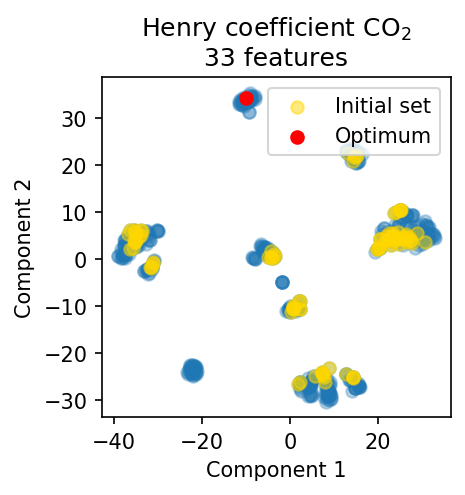

In [157]:
index_Henry_CO2 = np.argmax(Data_relevant_features_Henry_CO2.iloc[:, -1].values)
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(Data_relevant_features_Henry_CO2.iloc[:, :-1].values)
X_embedded.shape

SC1 = np.transpose(X_embedded)[0]
SC2 = np.transpose(X_embedded)[1]

fig, ax = plt.subplots(figsize=(3,3), dpi=150)
ax.scatter(SC1, SC2, c='tab:blue', alpha=0.3)
initial_set = ax.scatter(SC1[minima], SC2[minima], c='gold', label = 'Initial set', alpha = 0.5)
optimum = ax.scatter(SC1[index_Henry_CO2], SC2[index_Henry_CO2], c='red', label = 'Optimum')

ax.legend([initial_set, optimum], ['Initial set', 'Optimum'])
#labels = ['Initial set', 'Optimum']
#ax.legend(labels)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title('Henry coefficient CO$_2$\n33 features')
plt.show()

#### Non relevant features

In [31]:
MEI_index_Henry_CO2_unrelevant = MEI(Data_unrelevant_features_Henry_CO2.iloc[:, :-1].values, Data_unrelevant_features_Henry_CO2.iloc[:, -1].values, 400, 100)

 28%|██▊       | 114/400 [3:00:32<7:32:56, 95.02s/it]  


In [32]:
MLI_index_Henry_CO2_unrelevant = MLI(Data_unrelevant_features_Henry_CO2.iloc[:, :-1].values, Data_unrelevant_features_Henry_CO2.iloc[:, -1].values, 400, 100)

 10%|▉         | 39/400 [39:22<6:04:27, 60.57s/it]


In [33]:
MU_index_Henry_CO2_unrelevant = MU(Data_unrelevant_features_Henry_CO2.iloc[:, :-1].values, Data_unrelevant_features_Henry_CO2.iloc[:, -1].values, 400, 100)

 31%|███       | 123/400 [3:52:27<8:43:29, 113.39s/it] 


In [71]:
COMBO_PI_Henry_CO2_unrelevant = COMBO(Data_unrelevant_features_Henry_CO2, 'PI')

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood 20.85855926998478
50-th epoch, marginal likelihood 6.070687674273955
100-th epoch, marginal likelihood -3.285136444975862
150-th epoch, marginal likelihood -8.551105984942652
200-th epoch, marginal likelihood -11.84579721844429
250-th epoch, marginal likelihood -13.995875715619647
300-th epoch, marginal likelihood -15.508744845716578
350-th epoch, marginal likelihood -16.44409457615987
400-th epoch, marginal likelihood -17.136503746925683
450-th epoch, marginal likelihood -17.637876998915154
500-th epoch, marginal likelihood -18.053278414860685
Done

 Parameters of Gaussian kernel 
 
 width  =  [3.]
 scale  =  1.0
 scale2 =  1.0
 

0101-th step: f(x) = 11.087779 (action=150)
   current best f(x) = 11.087779 (best action=150) 

0102-th step: f(x) = 11.377510 (action=210)
   current best f(x) = 11.377510 (best action=210) 

0103-th step: f(x) = 11.509843 (action=34

In [72]:
COMBO_EI_Henry_CO2_unrelevant = COMBO(Data_unrelevant_features_Henry_CO2, 'EI')

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood 13.676339491936204
50-th epoch, marginal likelihood 1.5279730760355363
100-th epoch, marginal likelihood -5.742561308898502
150-th epoch, marginal likelihood -10.457303952423402
200-th epoch, marginal likelihood -13.23056107130705
250-th epoch, marginal likelihood -14.900032021357404
300-th epoch, marginal likelihood -16.18627656600708
350-th epoch, marginal likelihood -17.098878590329377
400-th epoch, marginal likelihood -17.764790297770162
450-th epoch, marginal likelihood -18.203218491323028
500-th epoch, marginal likelihood -18.67673942269773
Done

 Parameters of Gaussian kernel 
 
 width  =  [3.]
 scale  =  1.0
 scale2 =  1.0
 

0101-th step: f(x) = 11.087779 (action=150)
   current best f(x) = 11.087779 (best action=150) 

0102-th step: f(x) = 11.377510 (action=210)
   current best f(x) = 11.377510 (best action=210) 

0103-th step: f(x) = 11.509843 (action=

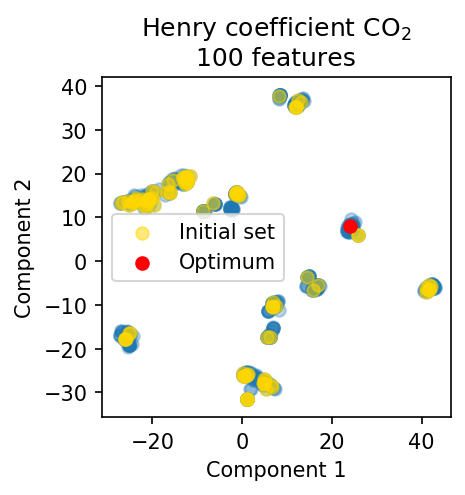

In [162]:
index_Henry_CO2_unrelevant = np.argmax(Data_unrelevant_features_Henry_CO2.iloc[:, -1].values)
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(Data_unrelevant_features_Henry_CO2.iloc[:, :-1].values)
X_embedded.shape

SC1 = np.transpose(X_embedded)[0]
SC2 = np.transpose(X_embedded)[1]

fig, ax = plt.subplots(figsize=(3,3), dpi=150)
ax.scatter(SC1, SC2, c='tab:blue', alpha=0.3)
initial_set = ax.scatter(SC1[minima], SC2[minima], c='gold', label = 'Initial set', alpha = 0.5)
optimum = ax.scatter(SC1[index_Henry_CO2_unrelevant], SC2[index_Henry_CO2_unrelevant], c='red', label = 'Optimum')

ax.legend([initial_set, optimum], ['Initial set', 'Optimum'])
#labels = ['Initial set', 'Optimum']
#ax.legend(labels)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title('Henry coefficient CO$_2$\n100 features')
plt.show()

## Working capacity

#### Relevant features

In [42]:
MEI_index_Working_Capacity_relevant = MEI(Data_relevant_features_Working_Capacity.iloc[:, :-1].values, Data_relevant_features_Working_Capacity.iloc[:, -1].values, 400, 100)

 22%|██▏       | 89/400 [1:28:18<5:08:34, 59.53s/it]


In [43]:
MLI_index_Working_Capacity_relevant = MLI(Data_relevant_features_Working_Capacity.iloc[:, :-1].values, Data_relevant_features_Working_Capacity.iloc[:, -1].values, 400, 100)

 42%|████▏     | 169/400 [4:42:50<6:26:35, 100.41s/it] 


In [44]:
MU_index_Working_Capacity_relevant = MU(Data_relevant_features_Working_Capacity.iloc[:, :-1].values, Data_relevant_features_Working_Capacity.iloc[:, -1].values, 400, 100)

 34%|███▎      | 134/400 [2:38:22<5:14:23, 70.92s/it] 


In [73]:
COMBO_PI_Working_Capacity_relevant = COMBO(Data_relevant_features_Working_Capacity, 'PI')

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood 31.670002602534495
50-th epoch, marginal likelihood 12.27689920672934
100-th epoch, marginal likelihood -0.09855475291846005
150-th epoch, marginal likelihood -7.516357923504643
200-th epoch, marginal likelihood -12.367663096393414
250-th epoch, marginal likelihood -15.809650953321338
300-th epoch, marginal likelihood -17.875276536147
350-th epoch, marginal likelihood -19.336553379590278
400-th epoch, marginal likelihood -20.376980120076453
450-th epoch, marginal likelihood -21.003640227675014
500-th epoch, marginal likelihood -21.508151335235198
Done

 Parameters of Gaussian kernel 
 
 width  =  [3.]
 scale  =  1.0
 scale2 =  1.0
 

0101-th step: f(x) = 1.954579 (action=267)
   current best f(x) = 1.954579 (best action=267) 

0102-th step: f(x) = 2.504622 (action=443)
   current best f(x) = 2.504622 (best action=443) 

0103-th step: f(x) = 2.317952 (action=10)
 

In [74]:
COMBO_EI_Working_Capacity_relevant = COMBO(Data_relevant_features_Working_Capacity, 'EI')

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood 29.90997320969744
50-th epoch, marginal likelihood 10.794170505191829
100-th epoch, marginal likelihood -0.9075471825976535
150-th epoch, marginal likelihood -8.368386914971154
200-th epoch, marginal likelihood -13.257961195127848
250-th epoch, marginal likelihood -16.014131550153778
300-th epoch, marginal likelihood -17.94129530471389
350-th epoch, marginal likelihood -19.372885445729196
400-th epoch, marginal likelihood -20.431542524574922
450-th epoch, marginal likelihood -21.181973189835446
500-th epoch, marginal likelihood -21.764358133226573
Done

 Parameters of Gaussian kernel 
 
 width  =  [3.]
 scale  =  1.0
 scale2 =  1.0
 

0101-th step: f(x) = 1.954579 (action=267)
   current best f(x) = 1.954579 (best action=267) 

0102-th step: f(x) = 2.504622 (action=443)
   current best f(x) = 2.504622 (best action=443) 

0103-th step: f(x) = 2.317952 (action=10)


KeyboardInterrupt: 

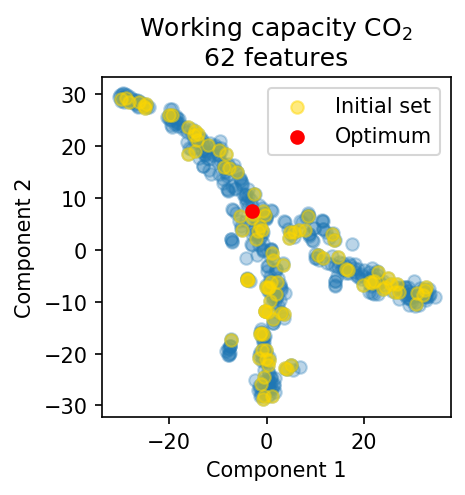

In [159]:
index_Working_Capacity_relevant = np.argmax(Data_relevant_features_Working_Capacity.iloc[:, -1].values)
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(Data_relevant_features_Working_Capacity.iloc[:, :-1].values)
X_embedded.shape

SC1 = np.transpose(X_embedded)[0]
SC2 = np.transpose(X_embedded)[1]

fig, ax = plt.subplots(figsize=(3,3), dpi=150)
ax.scatter(SC1, SC2, c='tab:blue', alpha=0.3)
initial_set = ax.scatter(SC1[minima], SC2[minima], c='gold', label = 'Initial set', alpha = 0.5)
optimum = ax.scatter(SC1[index_Working_Capacity_relevant], SC2[index_Working_Capacity_relevant], c='red', label = 'Optimum')

ax.legend([initial_set, optimum], ['Initial set', 'Optimum'])
#labels = ['Initial set', 'Optimum']
#ax.legend(labels)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title('Working capacity CO$_2$\n62 features')
plt.show()

#### Unrelevant features

In [45]:
MEI_index_Working_Capacity_unrelevant = MEI(Data_unrelevant_features_Working_Capacity.iloc[:, :-1].values, Data_unrelevant_features_Working_Capacity.iloc[:, -1].values, 400, 100)

 21%|██        | 84/400 [1:44:46<6:34:10, 74.84s/it]  


In [46]:
MLI_index_Working_Capacity_unrelevant = MLI(Data_unrelevant_features_Working_Capacity.iloc[:, :-1].values, Data_unrelevant_features_Working_Capacity.iloc[:, -1].values, 400, 100)

 43%|████▎     | 172/400 [6:34:42<8:43:13, 137.69s/it] 


In [50]:
MU_index_Working_Capacity_unrelevant = MU(Data_unrelevant_features_Working_Capacity.iloc[:, :-1].values, Data_unrelevant_features_Working_Capacity.iloc[:, -1].values, 400, 100)

 34%|███▍      | 136/400 [4:29:25<8:42:59, 118.86s/it] 


In [75]:
COMBO_PI_Working_Capacity_unrelevant = COMBO(Data_unrelevant_features_Working_Capacity, 'PI')

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood 20.23399653181788
50-th epoch, marginal likelihood 4.17222041902788
100-th epoch, marginal likelihood -6.08329759052495
150-th epoch, marginal likelihood -12.212935623798302
200-th epoch, marginal likelihood -16.229832835355737
250-th epoch, marginal likelihood -18.71919742589435
300-th epoch, marginal likelihood -20.17777184657949
350-th epoch, marginal likelihood -21.31155548617224
400-th epoch, marginal likelihood -21.995295207177733
450-th epoch, marginal likelihood -22.406180054205848
500-th epoch, marginal likelihood -22.764543446338358
Done

 Parameters of Gaussian kernel 
 
 width  =  [3.]
 scale  =  1.0
 scale2 =  1.0
 

0101-th step: f(x) = 1.954579 (action=267)
   current best f(x) = 1.954579 (best action=267) 

0102-th step: f(x) = 2.244285 (action=286)
   current best f(x) = 2.244285 (best action=286) 

0103-th step: f(x) = 3.222779 (action=197)
   c

In [77]:
COMBO_EI_Working_Capacity_unrelevant = COMBO(Data_unrelevant_features_Working_Capacity, 'EI')

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood 22.534308025707205
50-th epoch, marginal likelihood 6.161990523603947
100-th epoch, marginal likelihood -4.228448474831822
150-th epoch, marginal likelihood -11.032258789281855
200-th epoch, marginal likelihood -15.334852184358866
250-th epoch, marginal likelihood -17.860712897755818
300-th epoch, marginal likelihood -19.568793473947593
350-th epoch, marginal likelihood -20.90735978059798
400-th epoch, marginal likelihood -21.708358706694966
450-th epoch, marginal likelihood -22.26638217249598
500-th epoch, marginal likelihood -22.64482896230735
Done

 Parameters of Gaussian kernel 
 
 width  =  [3.]
 scale  =  1.0
 scale2 =  1.0
 

0101-th step: f(x) = 3.222779 (action=197)
   current best f(x) = 3.222779 (best action=197) 

0102-th step: f(x) = 4.107620 (action=223)
   current best f(x) = 4.107620 (best action=223) 

0103-th step: f(x) = 2.750888 (action=472)
 

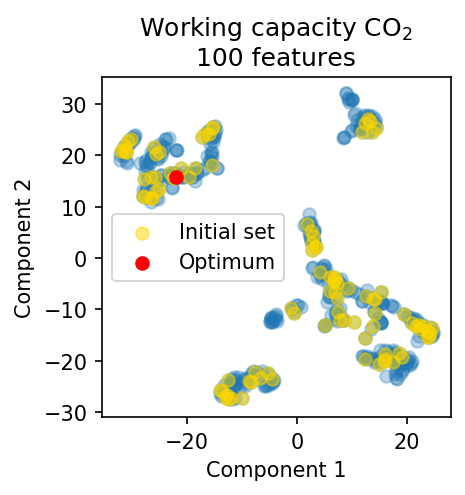

In [166]:
index_Working_Capacity_unrelevant = np.argmax(Data_unrelevant_features_Working_Capacity.iloc[:, -1].values)
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(Data_unrelevant_features_Working_Capacity.iloc[:, :-1].values)
X_embedded.shape

SC1 = np.transpose(X_embedded)[0]
SC2 = np.transpose(X_embedded)[1]

fig, ax = plt.subplots(figsize=(3,3), dpi=150)
ax.scatter(SC1, SC2, c='tab:blue', alpha=0.3)
initial_set = ax.scatter(SC1[minima], SC2[minima], c='gold', label = 'Initial set', alpha = 0.5)
optimum = ax.scatter(SC1[index_Working_Capacity_unrelevant], SC2[index_Working_Capacity_unrelevant], c='red', label = 'Optimum')

ax.legend([initial_set, optimum], ['Initial set', 'Optimum'], loc = 'best')
#labels = ['Initial set', 'Optimum']
#ax.legend(labels)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title('Working capacity CO$_2$\n100 features')
plt.show()

## Henry H2O

#### Relevant features

In [51]:
MEI_index_Henry_H2O_relevant = MEI(Data_relevant_features_Henry_H2O.iloc[:, :-1].values, Data_relevant_features_Henry_H2O.iloc[:, -1].values, 400, 100)

 36%|███▋      | 145/400 [1:06:14<1:56:30, 27.41s/it]


In [52]:
MLI_index_Henry_H2O_relevant = MLI(Data_relevant_features_Henry_H2O.iloc[:, :-1].values, Data_relevant_features_Henry_H2O.iloc[:, -1].values, 400, 100)

 15%|█▌        | 60/400 [18:29<1:44:44, 18.48s/it]


In [53]:
MU_index_Henry_H2O_relevant = MU(Data_relevant_features_Henry_H2O.iloc[:, :-1].values, Data_relevant_features_Henry_H2O.iloc[:, -1].values, 400, 100)

 46%|████▋     | 186/400 [1:53:43<2:10:50, 36.68s/it]


In [78]:
COMBO_PI_Henry_H2O_relevant = COMBO(Data_relevant_features_Henry_H2O, 'PI')

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood 420.57446795216663
50-th epoch, marginal likelihood 337.04118124318495
100-th epoch, marginal likelihood 279.20001945068645
150-th epoch, marginal likelihood 236.65148469546477
200-th epoch, marginal likelihood 204.39182930446677
250-th epoch, marginal likelihood 178.9697258179508
300-th epoch, marginal likelihood 160.8991206421631
350-th epoch, marginal likelihood 146.97395234742189
400-th epoch, marginal likelihood 135.75541725039443
450-th epoch, marginal likelihood 127.34189085032844
500-th epoch, marginal likelihood 120.54120578452829
Done

 Parameters of Gaussian kernel 
 
 width  =  [3.]
 scale  =  1.0
 scale2 =  1.0
 

0101-th step: f(x) = 9.631272 (action=449)
   current best f(x) = 9.631272 (best action=449) 

0102-th step: f(x) = 10.696403 (action=234)
   current best f(x) = 10.696403 (best action=234) 

0103-th step: f(x) = 10.066571 (action=367)
   c

In [79]:
COMBO_EI_Henry_H2O_relevant = COMBO(Data_relevant_features_Henry_H2O, 'EI')

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood 401.3852109666326
50-th epoch, marginal likelihood 322.27581227420285
100-th epoch, marginal likelihood 265.99044441426156
150-th epoch, marginal likelihood 224.94775209966633
200-th epoch, marginal likelihood 193.9614850436858
250-th epoch, marginal likelihood 172.1940030092809
300-th epoch, marginal likelihood 154.78123028236752
350-th epoch, marginal likelihood 142.08380163051442
400-th epoch, marginal likelihood 131.17126628102682
450-th epoch, marginal likelihood 122.7125951496197
500-th epoch, marginal likelihood 116.22044053085146
Done

 Parameters of Gaussian kernel 
 
 width  =  [3.]
 scale  =  1.0
 scale2 =  1.0
 

0101-th step: f(x) = 9.631272 (action=449)
   current best f(x) = 9.631272 (best action=449) 

0102-th step: f(x) = 10.696403 (action=234)
   current best f(x) = 10.696403 (best action=234) 

0103-th step: f(x) = 10.066571 (action=367)
   cur

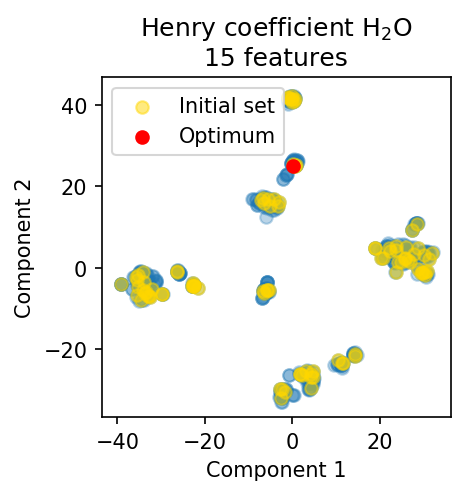

In [172]:
index_Henry_H2O_relevant = np.argmax(Data_relevant_features_Henry_H2O.iloc[:, -1].values)
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(Data_relevant_features_Henry_H2O.iloc[:, :-1].values)
X_embedded.shape

SC1 = np.transpose(X_embedded)[0]
SC2 = np.transpose(X_embedded)[1]

fig, ax = plt.subplots(figsize=(3,3), dpi=150)
ax.scatter(SC1, SC2, c='tab:blue', alpha=0.3)
initial_set = ax.scatter(SC1[minima], SC2[minima], c='gold', label = 'Initial set', alpha = 0.5)
optimum = ax.scatter(SC1[index_Henry_H2O_relevant], SC2[index_Henry_H2O_relevant], c='red', label = 'Optimum')

ax.legend([initial_set, optimum], ['Initial set', 'Optimum'], loc = 'best')
#labels = ['Initial set', 'Optimum']
#ax.legend(labels)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title('Henry coefficient H$_2$O\n15 features')
plt.show()

#### Unrelevant features

In [55]:
MEI_index_Henry_H2O_unrelevant = MEI(Data_unrelevant_features_Henry_H2O.iloc[:, :-1].values, Data_unrelevant_features_Henry_H2O.iloc[:, -1].values, 400, 100)

 32%|███▏      | 126/400 [3:56:34<8:34:27, 112.65s/it] 


In [58]:
MLI_index_Henry_H2O_unrelevant = MLI(Data_unrelevant_features_Henry_H2O.iloc[:, :-1].values, Data_unrelevant_features_Henry_H2O.iloc[:, -1].values, 400, 100)

 11%|█▏        | 45/400 [47:30<6:14:46, 63.34s/it]


In [59]:
MU_index_Henry_H2O_unrelevant = MU(Data_unrelevant_features_Henry_H2O.iloc[:, :-1].values, Data_unrelevant_features_Henry_H2O.iloc[:, -1].values, 400, 100)

 36%|███▋      | 146/400 [5:47:38<10:04:48, 142.87s/it]


In [80]:
COMBO_PI_Henry_H2O_unrelevant = COMBO(Data_unrelevant_features_Henry_H2O, 'PI')

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood 130.23433735372925
50-th epoch, marginal likelihood 109.58697821701463
100-th epoch, marginal likelihood 96.2012237062626
150-th epoch, marginal likelihood 87.64336623074306
200-th epoch, marginal likelihood 81.91116964160187
250-th epoch, marginal likelihood 78.34120400801716
300-th epoch, marginal likelihood 75.67185153214187
350-th epoch, marginal likelihood 73.73369240724969
400-th epoch, marginal likelihood 72.23980862313533
450-th epoch, marginal likelihood 71.35416817002937
500-th epoch, marginal likelihood 70.49305096668175
Done

 Parameters of Gaussian kernel 
 
 width  =  [3.]
 scale  =  1.0
 scale2 =  1.0
 

0101-th step: f(x) = 9.259340 (action=329)
   current best f(x) = 9.259340 (best action=329) 

0102-th step: f(x) = 8.646613 (action=421)
   current best f(x) = 9.259340 (best action=329) 

0103-th step: f(x) = 9.985689 (action=276)
   current best

In [81]:
COMBO_EI_Henry_H2O_unrelevant = COMBO(Data_unrelevant_features_Henry_H2O, 'EI')

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood 126.16405652556539
50-th epoch, marginal likelihood 106.3128654802206
100-th epoch, marginal likelihood 93.516855017446
150-th epoch, marginal likelihood 85.08211186675123
200-th epoch, marginal likelihood 80.07957791040582
250-th epoch, marginal likelihood 76.72947167263035
300-th epoch, marginal likelihood 74.37097683457849
350-th epoch, marginal likelihood 72.82285115159661
400-th epoch, marginal likelihood 71.65306326741191
450-th epoch, marginal likelihood 70.84009345504086
500-th epoch, marginal likelihood 70.16149202931157
Done

 Parameters of Gaussian kernel 
 
 width  =  [3.]
 scale  =  1.0
 scale2 =  1.0
 

0101-th step: f(x) = 9.259340 (action=329)
   current best f(x) = 9.259340 (best action=329) 

0102-th step: f(x) = 8.646613 (action=421)
   current best f(x) = 9.259340 (best action=329) 

0103-th step: f(x) = 9.985689 (action=276)
   current best f

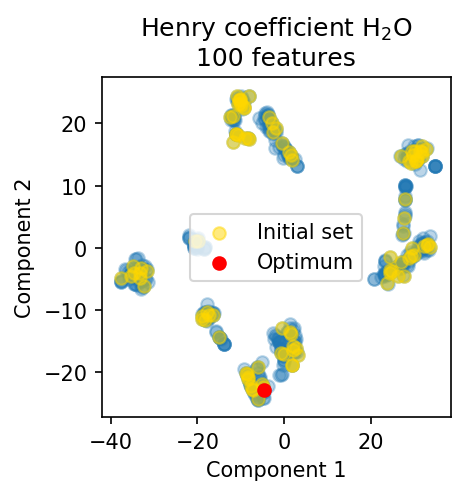

In [169]:
index_Henry_H2O_unrelevant = np.argmax(Data_unrelevant_features_Henry_H2O.iloc[:, -1].values)
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(Data_unrelevant_features_Henry_H2O.iloc[:, :-1].values)
X_embedded.shape

SC1 = np.transpose(X_embedded)[0]
SC2 = np.transpose(X_embedded)[1]

fig, ax = plt.subplots(figsize=(3,3), dpi=150)
ax.scatter(SC1, SC2, c='tab:blue', alpha=0.3)
initial_set = ax.scatter(SC1[minima], SC2[minima], c='gold', label = 'Initial set', alpha = 0.5)
optimum = ax.scatter(SC1[index_Henry_H2O_unrelevant], SC2[index_Henry_H2O_unrelevant], c='red', label = 'Optimum')

ax.legend([initial_set, optimum], ['Initial set', 'Optimum'], loc = 'best')
#labels = ['Initial set', 'Optimum']
#ax.legend(labels)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title('Henry coefficient H$_2$O\n100 features')
plt.show()

## Squential Learning results summary (with Kriging)

### Henry_CO2

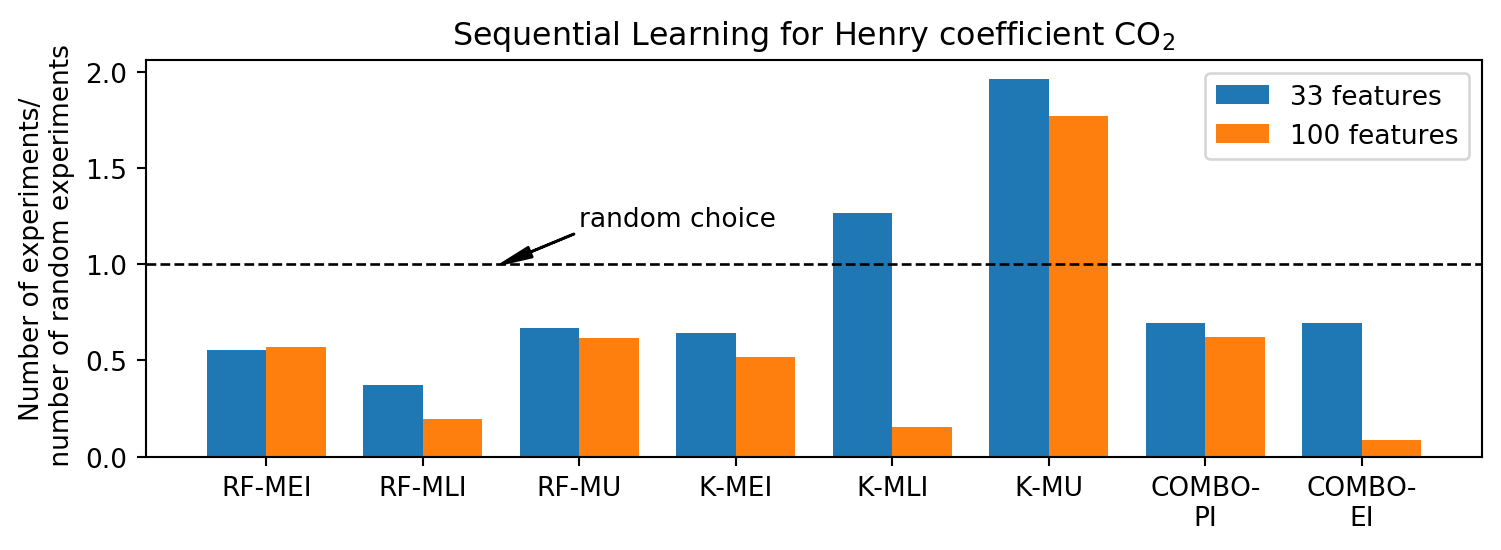

In [102]:
labels = ['RF-MEI', 'RF-MLI', 'RF-MU', 'K-MEI', 'K-MLI', 'K-MU', 'COMBO-\nPI', 'COMBO-\nEI' ]
relevant = [111/200, 74/200, 134/200, 129/200, 253/200, 393/200, 139/200, 139/200]
unrelevant = [114/200, 39/200, 123/200, 104/200, 31/200, 354/200, 124/200, 17/200]

x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 3)  , dpi=190)

#ax.hlines(1, xmin = men_means[3], xmax = men_means[4])
#fig, ax = plt.subplots(figsize=(7,3)  , dpi=140)
rects1 = ax.bar(x - width/2, relevant, width, label='33 features')
rects2 = ax.bar(x + width/2, unrelevant, width, label='100 features')
plt.axhline(y=1, color = 'k', linewidth = 1, linestyle="--")
# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_ylabel('Number of experiments/\n number of random experiments')
#ax.set_title('Results for synthetic data')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_title('Sequential Learning for Henry coefficient CO$_2$')


ax.annotate('random choice', xy=(1.5, 1), xytext=(2, 1.2),
            arrowprops=dict(facecolor='black', width = .1, headwidth=4),
            )


fig.tight_layout()

plt.show()

### Working capacity

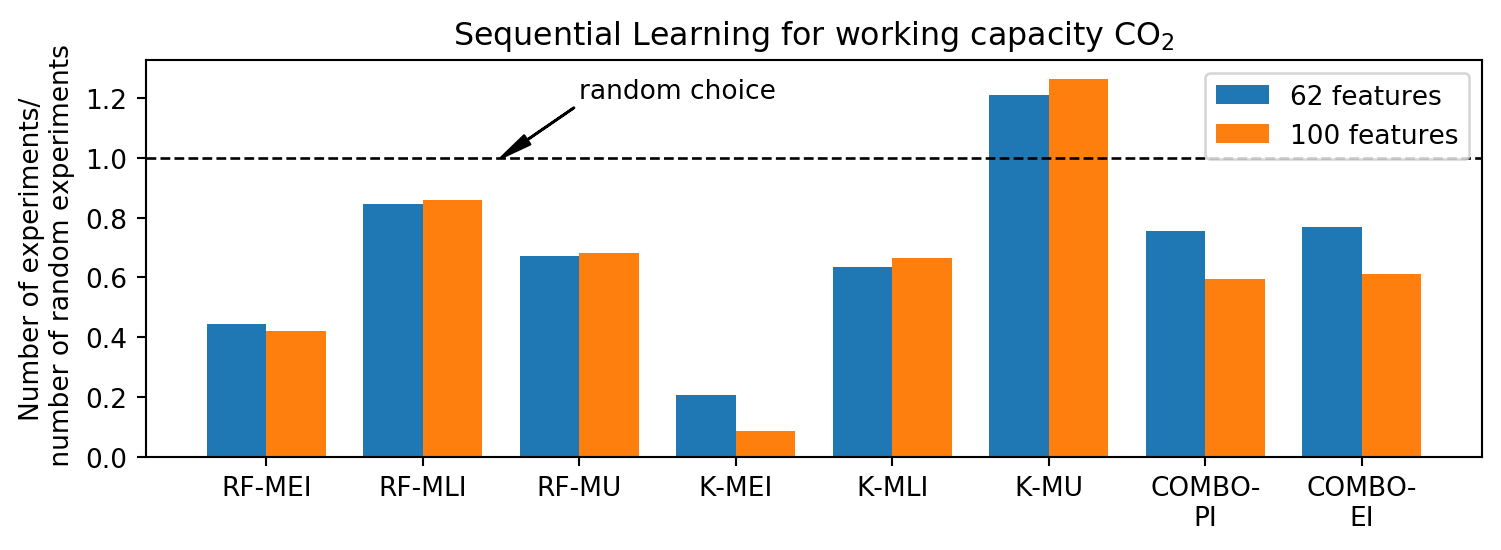

In [106]:
labels = ['RF-MEI', 'RF-MLI', 'RF-MU', 'K-MEI', 'K-MLI', 'K-MU', 'COMBO-\nPI', 'COMBO-\nEI' ]
relevant = [89/200, 169/200, 134/200, 41/200, 127/200, 242/200, 151/200, 154/200]
unrelevant = [84/200, 172/200, 136/200, 17/200, 133/200, 253/200, 119/200, 122/200]

x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 3)  , dpi=190)

#ax.hlines(1, xmin = men_means[3], xmax = men_means[4])
#fig, ax = plt.subplots(figsize=(7,3)  , dpi=140)
rects1 = ax.bar(x - width/2, relevant, width, label='62 features')
rects2 = ax.bar(x + width/2, unrelevant, width, label='100 features')
plt.axhline(y=1, color = 'k', linewidth = 1, linestyle="--")
# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_ylabel('Number of experiments/\n number of random experiments')
#ax.set_title('Results for synthetic data')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_title('Sequential Learning for working capacity CO$_2$')


ax.annotate('random choice', xy=(1.5, 1), xytext=(2, 1.2),
            arrowprops=dict(facecolor='black', width = .1, headwidth=4),
            )


fig.tight_layout()

plt.show()

### Henry H2O

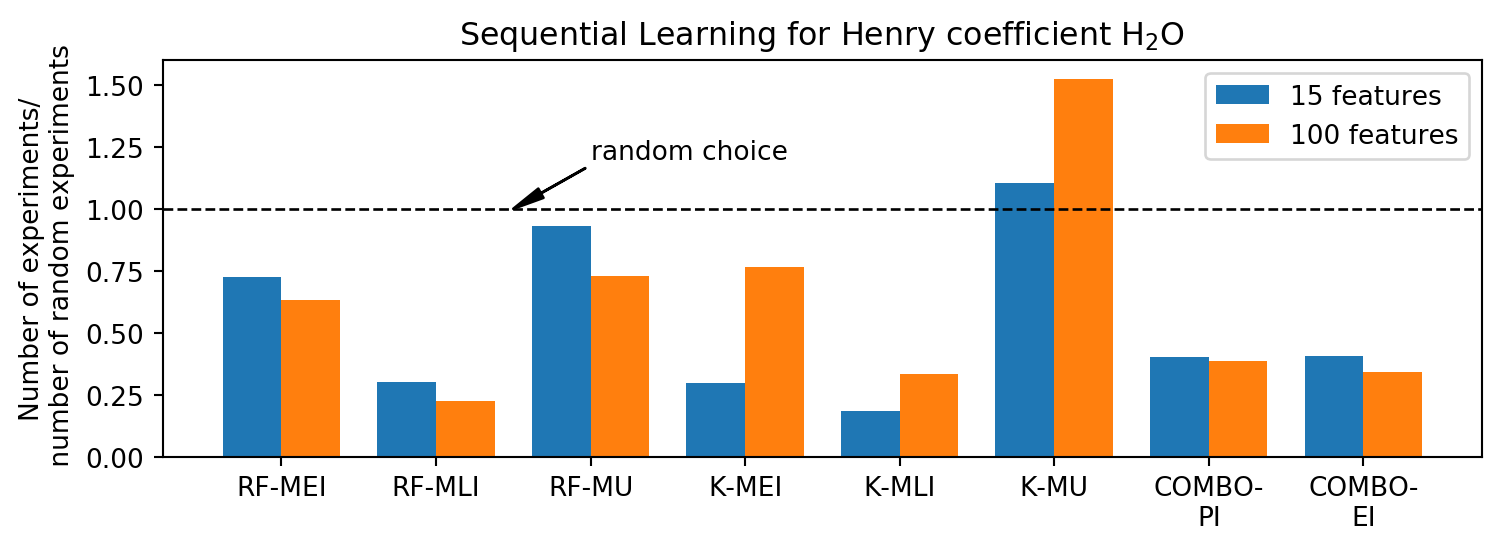

In [109]:
labels = ['RF-MEI', 'RF-MLI', 'RF-MU', 'K-MEI', 'K-MLI', 'K-MU', 'COMBO-\nPI', 'COMBO-\nEI' ]
relevant = [145/200, 60/200, 186/200, 59/200, 37/200, 221/200, 80/200, 81/200]
unrelevant = [126/200, 45/200, 146/200, 153/200, 67/200, 305/200, 77/200, 68/200]

x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 3)  , dpi=190)

#ax.hlines(1, xmin = men_means[3], xmax = men_means[4])
#fig, ax = plt.subplots(figsize=(7,3)  , dpi=140)
rects1 = ax.bar(x - width/2, relevant, width, label='15 features')
rects2 = ax.bar(x + width/2, unrelevant, width, label='100 features')
plt.axhline(y=1, color = 'k', linewidth = 1, linestyle="--")
# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_ylabel('Number of experiments/\n number of random experiments')
#ax.set_title('Results for synthetic data')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_title('Sequential Learning for Henry coefficient H$_2$O')


ax.annotate('random choice', xy=(1.5, 1), xytext=(2, 1.2),
            arrowprops=dict(facecolor='black', width = .1, headwidth=4),
            )


fig.tight_layout()

plt.show()